In [2]:
# open FlatVelA/data/data1.npy
import numpy as np
data = np.load('data/train_samples/FlatVel_A/data/data49.npy')
velocity = np.load('data/train_samples/FlatVel_A/model/model49.npy')
# print the shape of the data
print(data.shape)
# plot sample 14 imshow 

(500, 5, 1000, 70)


In [3]:
import matplotlib.pyplot as plt
## Select a sample in the data
sample=14

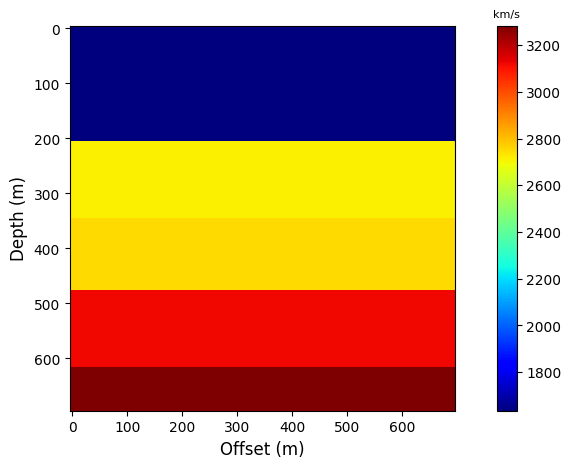

In [4]:
from matplotlib.colors import ListedColormap
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
img=ax.imshow(velocity[sample,0,:,:],cmap='jet')
ax.set_xticks(range(0, 70, 10))
ax.set_xticklabels(range(0, 700, 100))
ax.set_yticks(range(0, 70, 10))
ax.set_yticklabels(range(0, 700, 100))
ax.set_ylabel('Depth (m)', fontsize=12)
ax.set_xlabel('Offset (m)', fontsize=12)
clb=plt.colorbar(img, ax=ax)
clb.ax.set_title('km/s',fontsize=8)
plt.show()

In [5]:
import pywt
import numpy as np

# Assume `vel_map` is a 2D NumPy array representing the velocity model
wavelet = 'haar'  # Haar wavelet (good for piecewise constant signals)
level = 3         # Decomposition level (e.g., 3 levels)

# Perform multilevel 2D wavelet decomposition
coeffs = pywt.wavedec2(velocity[sample,0,:,:], wavelet=wavelet, level=level)
cA, *detail_coeffs = coeffs  # cA is approximation, detail_coeffs = [(cH, cV, cD), ...]

# Threshold small coefficients in detail sub-bands to denoise (soft threshold)
threshold = 0.05 * np.max([np.max(abs(c)) for band in detail_coeffs for c in band])
detail_coeffs_thresh = []
for (cH, cV, cD) in detail_coeffs:
    cH_t = pywt.threshold(cH, threshold, mode='soft')
    cV_t = pywt.threshold(cV, threshold, mode='soft')
    cD_t = pywt.threshold(cD, threshold, mode='soft')
    detail_coeffs_thresh.append((cH_t, cV_t, cD_t))

# Reconstruct image from thresholded coefficients
coeffs_thresh = [cA] + detail_coeffs_thresh
vel_denoised = pywt.waverec2(coeffs_thresh, wavelet=wavelet)
vel_denoised = pywt.waverec2(coeffs_thresh, wavelet=wavelet)

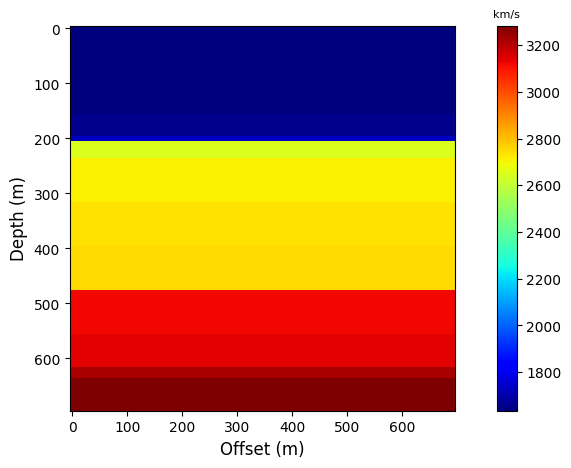

In [6]:
# plot denoised image
fig, ax = plt.subplots(1, 1, figsize=(11, 5))
img=ax.imshow(vel_denoised, cmap='jet')
ax.set_xticks(range(0, 70, 10))
ax.set_xticklabels(range(0, 700, 100))
ax.set_yticks(range(0, 70, 10))
ax.set_yticklabels(range(0, 700, 100))
ax.set_ylabel('Depth (m)', fontsize=12)
ax.set_xlabel('Offset (m)', fontsize=12)
clb=plt.colorbar(img, ax=ax)
clb.ax.set_title('km/s', fontsize=8)
plt.show()

In [7]:
import torch
# Check if MPS (Metal Performance Shaders) is available for Apple Silicon
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

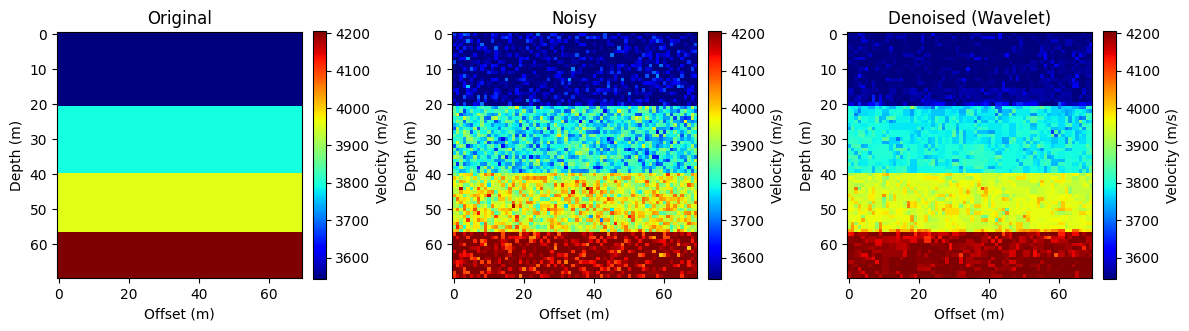

Wavelet Thresholding -> MSE: 825.077169, PSNR: 27.24 dB, SSIM: 0.5503


In [8]:
import numpy as np
import pywt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Load velocity data (shape: 500 x 1 x 70 x 70)
velocity = np.load('data/train_samples/FlatVel_A/model/model49.npy')
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)

# Add Gaussian noise to the clean map
noise_std = 0.1 * (clean_map.max() - clean_map.min())  # e.g., 10% of dynamic range
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Wavelet decomposition (Haar wavelet)
wavelet = 'haar'
coeffs = pywt.wavedec2(noisy_map, wavelet=wavelet, mode='periodization')
# Determine threshold (e.g., universal threshold or scaled noise level)
threshold = noise_std  # simple choice: equal to noise std (adjust as needed)
# Apply soft thresholding to detail coeffs (skip the approximation coeff at index 0)
coeffs_thresh = [coeffs[0]]  # keep approximation coefficients unmodified
for detail_level in coeffs[1:]:
    cH, cV, cD = detail_level
    cH_t = pywt.threshold(cH, value=threshold, mode='soft')
    cV_t = pywt.threshold(cV, value=threshold, mode='soft')
    cD_t = pywt.threshold(cD, value=threshold, mode='soft')
    coeffs_thresh.append((cH_t, cV_t, cD_t))

# Reconstruct the denoised image from thresholded coefficients
denoised_map = pywt.waverec2(coeffs_thresh, wavelet=wavelet, mode='periodization')

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
# Original
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax)
axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)")
plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04, label='Velocity (m/s)')
# Noisy
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax)
axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04, label='Velocity (m/s)')
# Denoised (Wavelet)
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax)
axs[2].set_title("Denoised (Wavelet)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04, label='Velocity (m/s)')
plt.tight_layout()
plt.show()

print(f"Wavelet Thresholding -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

In [9]:
# print the original velocity map data
print("Original Velocity Map Data (Sample 0):")
print(clean_map)
print("Noisy Velocity Map Data (Sample 0):")
print(noisy_map)

Original Velocity Map Data (Sample 0):
[[3544. 3544. 3544. ... 3544. 3544. 3544.]
 [3544. 3544. 3544. ... 3544. 3544. 3544.]
 [3544. 3544. 3544. ... 3544. 3544. 3544.]
 ...
 [4205. 4205. 4205. ... 4205. 4205. 4205.]
 [4205. 4205. 4205. ... 4205. 4205. 4205.]
 [4205. 4205. 4205. ... 4205. 4205. 4205.]]
Noisy Velocity Map Data (Sample 0):
[[3660.60385738 3570.45039086 3608.69457926 ... 3574.58990638
  3484.0275795  3547.43359058]
 [3592.19288505 3552.5257702  3619.31438351 ... 3530.23145257
  3570.1760431  3471.74863594]
 [3445.4278754  3573.04379078 3555.01711779 ... 3495.21615803
  3562.50301557 3537.51225939]
 ...
 [4252.31328715 4215.48792474 4193.92097403 ... 4239.87967874
  4190.28473511 4172.51284093]
 [4099.64721092 4272.31446009 4208.2841927  ... 4176.82683799
  4182.85307443 4195.19786126]
 [4115.46195878 4163.03679093 4196.01885658 ... 4310.25933682
  4202.26063882 4295.94973629]]


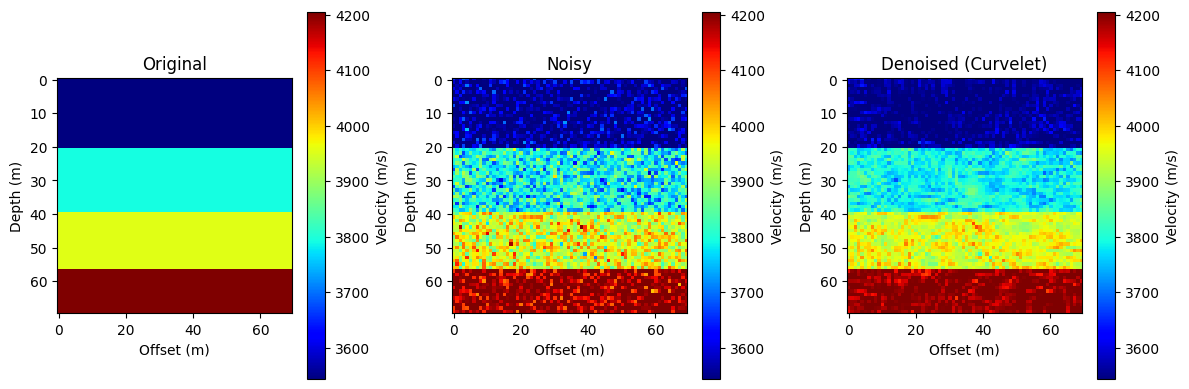

Curvelet Thresholding -> MSE: 1307.637842, PSNR: 25.24 dB, SSIM: 0.4502


In [10]:
import numpy as np
from curvelets.numpy import SimpleUDCT
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
import matplotlib.pyplot as plt

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Pad image to next power-of-2 size for curvelet transform
rows, cols = clean_map.shape
new_size = 1
while new_size < max(rows, cols):
    new_size *= 2
pad_y_top = (new_size - rows) // 2
pad_y_bottom = new_size - rows - pad_y_top
pad_x_left = (new_size - cols) // 2
pad_x_right = new_size - cols - pad_x_left
noisy_pad = np.pad(noisy_map, ((pad_y_top, pad_y_bottom), (pad_x_left, pad_x_right)), mode='edge')

# Curvelet transform (forward)
udct = SimpleUDCT(noisy_pad.shape)
coeffs = udct.forward(noisy_pad)

# Thresholding small coefficients (nested thresholding)
threshold = noise_std
coeffs_thresh = [
    [np.where(np.abs(c) < threshold, 0, c) for c in scale]
    for scale in coeffs
]

# Inverse curvelet transform (reconstruction)
denoised_pad = udct.backward(coeffs_thresh)
denoised_map = denoised_pad[pad_y_top:pad_y_top+rows, pad_x_left:pad_x_left+cols]

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot results
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Curvelet)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Curvelet Thresholding -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

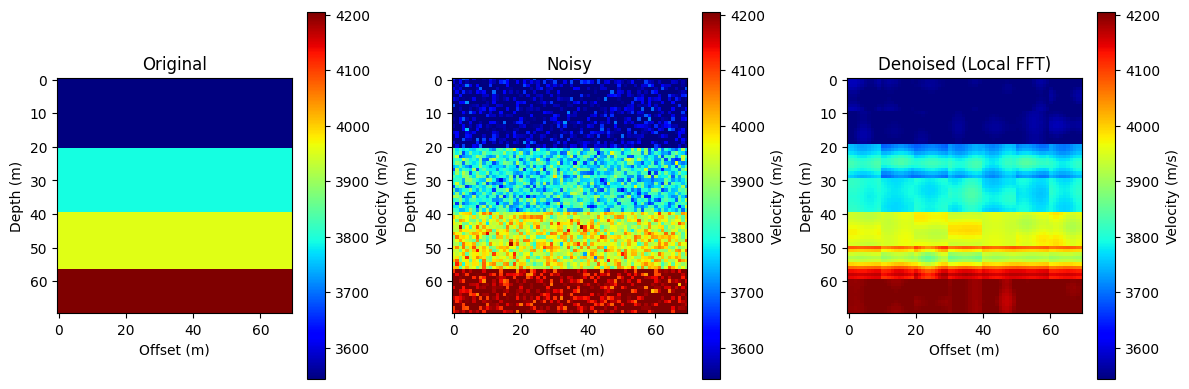

Local Fourier Filtering (STFT) -> MSE: 1486.845411, PSNR: 24.68 dB, SSIM: 0.6189


In [11]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Patch-wise local Fourier filtering
patch_size = 10  # size of each square patch
denoised_map = np.zeros_like(noisy_map)
# Loop over non-overlapping patches
for i in range(0, clean_map.shape[0], patch_size):
    for j in range(0, clean_map.shape[1], patch_size):
        patch = noisy_map[i:i+patch_size, j:j+patch_size]
        # Compute 2D FFT of the patch
        F = np.fft.fft2(patch)
        F_shift = np.fft.fftshift(F)
        # Create a low-pass circular mask in the patch's frequency domain
        rows, cols = patch.shape
        crow, ccol = rows // 2, cols // 2
        r = 1  # radius of low-frequency pass (in frequency pixels)
        mask = np.zeros((rows, cols), dtype=float)
        for u in range(rows):
            for v in range(cols):
                if (u - crow)**2 + (v - ccol)**2 <= r*r:
                    mask[u, v] = 1.0
        # Apply mask and inverse FFT
        F_shift_filtered = F_shift * mask
        F_filtered = np.fft.ifftshift(F_shift_filtered)
        patch_denoised = np.fft.ifft2(F_filtered).real
        # Put the filtered patch back into the output image
        denoised_map[i:i+patch_size, j:j+patch_size] = patch_denoised

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)"); plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Local FFT)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Local Fourier Filtering (STFT) -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

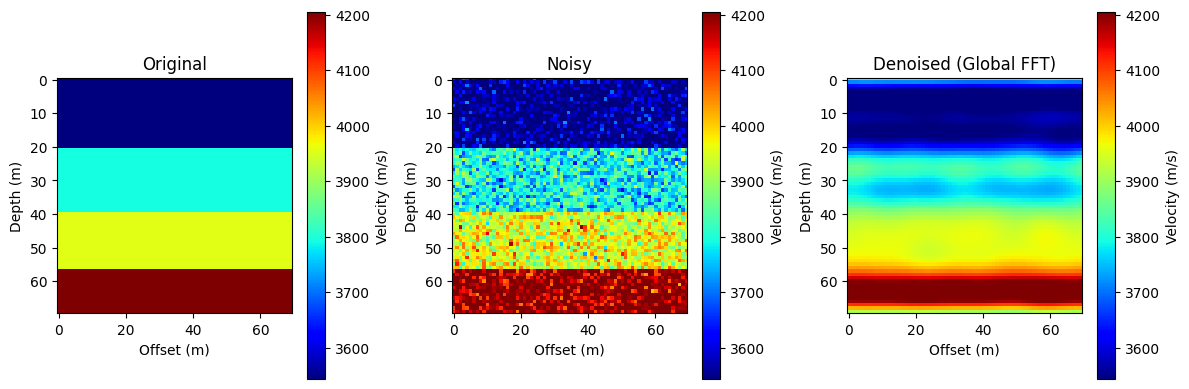

Global DFT Low-pass -> MSE: 5214.357070, PSNR: 19.23 dB, SSIM: 0.5247


In [12]:
import numpy as np
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Global 2D FFT of the noisy image
F = np.fft.fft2(noisy_map)
F_shift = np.fft.fftshift(F)
# Create a low-pass mask (keep frequencies within a radius r of the center)
rows, cols = noisy_map.shape
crow, ccol = rows // 2, cols // 2
r = 5  # low-pass radius in frequency domain (tune this parameter)
mask = np.zeros((rows, cols), dtype=float)
for u in range(rows):
    for v in range(cols):
        if (u - crow)**2 + (v - ccol)**2 <= r*r:
            mask[u, v] = 1.0
# Apply mask and inverse FFT to get filtered image
F_shift_filtered = F_shift * mask
F_filtered = np.fft.ifftshift(F_shift_filtered)
denoised_map = np.fft.ifft2(F_filtered).real

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Global FFT)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Global DFT Low-pass -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

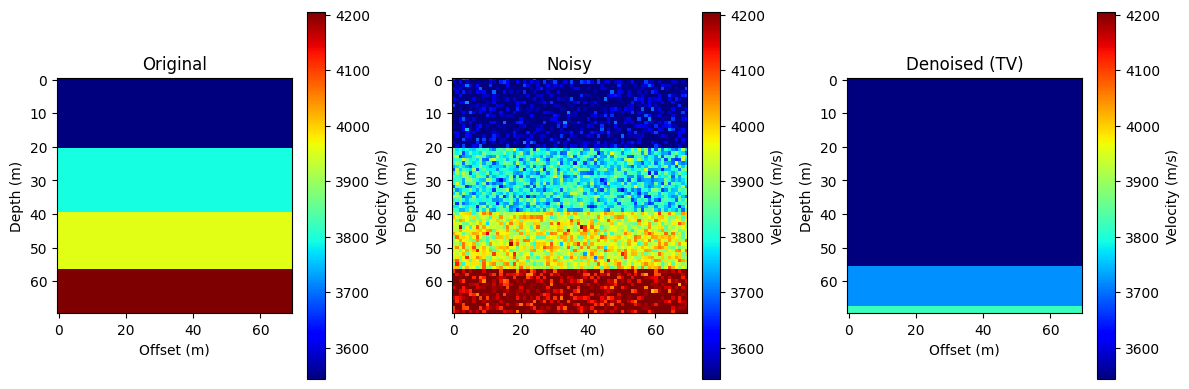

TV Denoising -> MSE: 1555405.010227, PSNR: -5.51 dB, SSIM: 0.5074


In [27]:
import numpy as np
from skimage.restoration import denoise_tv_chambolle
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare the clean and noisy image
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Total Variation denoising using Chambolle’s method
denoise_tv_chambolle(noisy_map, weight=0.1, channel_axis=None)  # adjust weight as needed

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (TV)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"TV Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13

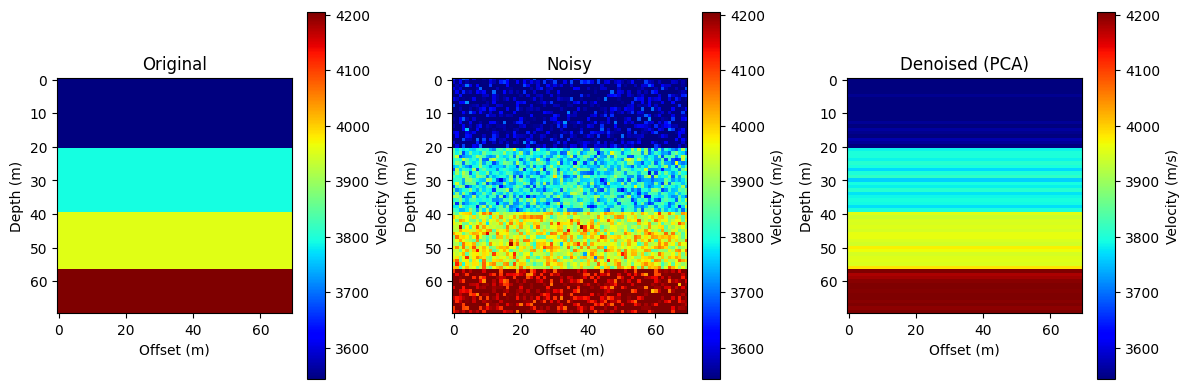

PCA Denoising -> MSE: 167.942017, PSNR: 34.15 dB, SSIM: 0.8062


In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare training data for PCA (e.g., use first 100 clean velocity maps)
X_train = velocity[:100, 0].reshape(100, -1).astype(np.float32)  # shape: (100, 4900)
# Normalize training data (optional): subtract mean
X_mean = X_train.mean(axis=0)
X_train_centered = X_train - X_mean
# Fit PCA on training set
pca = PCA(n_components=50)  # keep 50 principal components (adjust for desired fidelity)
pca.fit(X_train_centered)

# Select a sample and add noise
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# PCA denoising: project noisy image onto PCA space and reconstruct
noisy_flat = noisy_map.flatten().astype(np.float32)
noisy_flat_centered = noisy_flat - X_mean  # center using training mean
coef = pca.transform(noisy_flat_centered.reshape(1, -1))  # PCA coefficients (1 x n_components)
recon_flat = pca.inverse_transform(coef)  # reconstruct in centered space
recon_flat = recon_flat.reshape(-1) + X_mean  # add back mean
denoised_map = recon_flat.reshape(clean_map.shape)

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (PCA)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"PCA Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13

/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:350: RuntimeWarning: invalid value encountered in matmul
  Q, _ = normalizer(A @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: divide by zero encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13/site-packages/sklearn/utils/extmath.py:351: RuntimeWarning: overflow encountered in matmul
  Q, _ = normalizer(A.T @ Q)
/Users/ian/Documents/research/mat271project/.venv/lib/python3.13

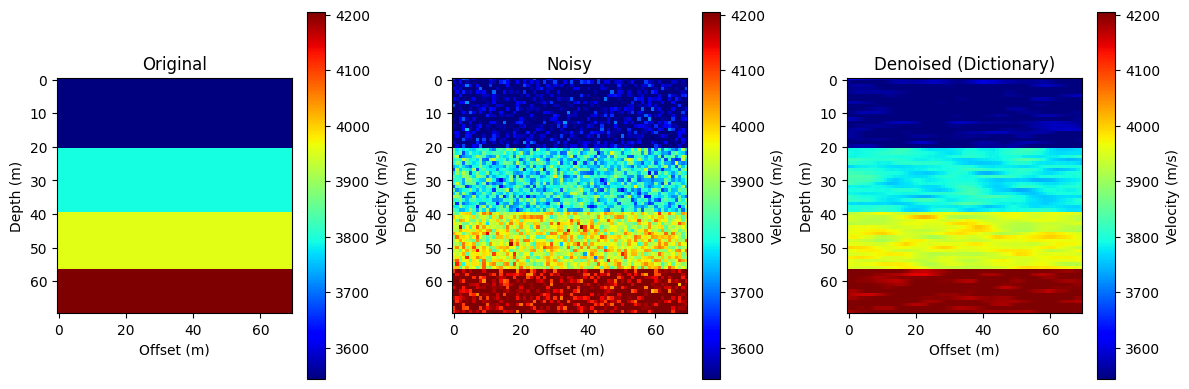

Dictionary Learning Denoising -> MSE: 363.288763, PSNR: 30.80 dB, SSIM: 0.7013


In [ ]:
import numpy as np
from sklearn.feature_extraction.image import extract_patches_2d, reconstruct_from_patches_2d
from sklearn.decomposition import MiniBatchDictionaryLearning
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Prepare training patches from multiple clean velocity maps
patch_size = (7, 7)
num_train_images = 100
patches_per_image = 100
np.random.seed(0)
patch_list = []
for i in range(num_train_images):
    img = velocity[i, 0].astype(np.float32)
    patches = extract_patches_2d(img, patch_size, max_patches=patches_per_image, random_state=0)
    # Flatten patches to 1D vectors
    patches = patches.reshape(patches.shape[0], -1)
    patch_list.append(patches)
training_patches = np.vstack(patch_list)  # shape: (num_train_images*patches_per_image, patch_size[0]*patch_size[1])
# Normalize patches for training (zero-mean, unit-std)
patch_mean = training_patches.mean(axis=0)
patch_std = training_patches.std(axis=0) + 1e-8
training_patches_norm = (training_patches - patch_mean) / patch_std

# Learn dictionary of patch atoms using sparse coding
dico = MiniBatchDictionaryLearning(n_components=100, alpha=1.0, max_iter=500, batch_size=256, random_state=0)
dico.fit(training_patches_norm)
dictionary = dico.components_  # shape: (100, 49) for 7x7 patches

# Denoise a sample image using the learned dictionary
sample_index = 0
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())
np.random.seed(0)
noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

# Extract overlapping patches from the noisy image
noisy_patches = extract_patches_2d(noisy_map, patch_size)
orig_shape = noisy_map.shape
noisy_patches_flat = noisy_patches.reshape(noisy_patches.shape[0], -1)
# Normalize patches using training mean and std
noisy_patches_norm = (noisy_patches_flat - patch_mean) / patch_std
# Sparse encode the noisy patches with the trained dictionary
code = dico.transform(noisy_patches_norm)   # sparse codes for each patch
# Reconstruct patches from sparse codes
recon_patches_flat = code.dot(dictionary)   # multiply codes by dictionary atoms
# Denormalize reconstructed patches
recon_patches_flat = recon_patches_flat * patch_std + patch_mean
recon_patches = recon_patches_flat.reshape(-1, patch_size[0], patch_size[1])
# Reconstruct the denoised image from patches
denoised_map = reconstruct_from_patches_2d(recon_patches, orig_shape)

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
import matplotlib.pyplot as plt
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Dictionary)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Dictionary Learning Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")

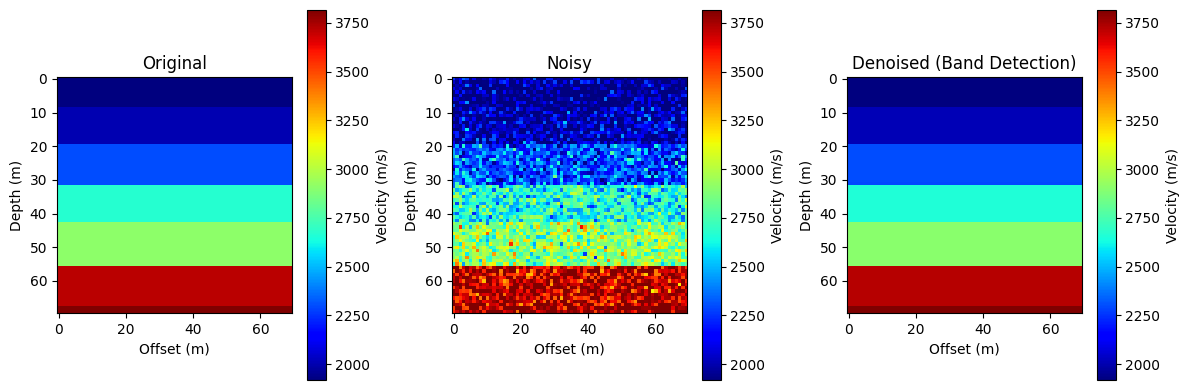

Band Detection Denoising -> MSE: 43.935045, PSNR: 49.14 dB, SSIM: 0.9993


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# Function to apply the band detection + reconstruction method
def band_denoising(clean_map, noise_std, window=5):
    # Add noise
    np.random.seed(0)
    noisy_map = clean_map + noise_std * np.random.randn(*clean_map.shape)

    # Vertical profile smoothing
    row_mean = noisy_map.mean(axis=1)
    pad = window // 2
    padded = np.pad(row_mean, pad, mode='edge')
    smoothed_profile = np.array([np.median(padded[i:i+window]) for i in range(len(row_mean))])

    # Detect band boundaries
    diff = np.diff(smoothed_profile)
    threshold = noise_std / 5
    boundary_indices = np.where(np.abs(diff) > threshold)[0]

    # Band segmentation
    band_bounds = []
    current_start = 0
    for idx in boundary_indices:
        band_bounds.append((current_start, idx))
        current_start = idx + 1
    band_bounds.append((current_start, len(row_mean) - 1))

    # Bandwise averaging
    band_velocities = []
    for (i, j) in band_bounds:
        band_val = noisy_map[i:j+1, :].mean()
        band_velocities.append(band_val)

    # Reconstruct denoised map
    recon_map = np.zeros_like(noisy_map)
    for (i, j), val in zip(band_bounds, band_velocities):
        recon_map[i:j+1, :] = val

    return noisy_map, recon_map, len(band_bounds)

# Now apply to a real velocity map
sample_index = 100
clean_map = velocity[sample_index, 0].astype(np.float32)
noise_std = 0.1 * (clean_map.max() - clean_map.min())

noisy_map, denoised_map, num_bands = band_denoising(clean_map, noise_std)

# Compute error metrics
mse = np.mean((denoised_map - clean_map) ** 2)
psnr = peak_signal_noise_ratio(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())
ssim_val = structural_similarity(clean_map, denoised_map, data_range=clean_map.max()-clean_map.min())

# Plot original, noisy, and denoised images
vmin, vmax = clean_map.min(), clean_map.max()
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
im0 = axs[0].imshow(clean_map, cmap='jet', vmin=vmin, vmax=vmax); axs[0].set_title("Original")
axs[0].set_xlabel("Offset (m)"); axs[0].set_ylabel("Depth (m)"); plt.colorbar(im0, ax=axs[0], label='Velocity (m/s)')
im1 = axs[1].imshow(noisy_map, cmap='jet', vmin=vmin, vmax=vmax); axs[1].set_title("Noisy")
axs[1].set_xlabel("Offset (m)"); axs[1].set_ylabel("Depth (m)")
plt.colorbar(im1, ax=axs[1], label='Velocity (m/s)')
im2 = axs[2].imshow(denoised_map, cmap='jet', vmin=vmin, vmax=vmax); axs[2].set_title("Denoised (Band Detection)")
axs[2].set_xlabel("Offset (m)"); axs[2].set_ylabel("Depth (m)")
plt.colorbar(im2, ax=axs[2], label='Velocity (m/s)')
plt.tight_layout(); plt.show()

print(f"Band Detection Denoising -> MSE: {mse:.6f}, PSNR: {psnr:.2f} dB, SSIM: {ssim_val:.4f}")


--- Denoising Performance on Inverted Velocity Maps ---
        Method        MSE     PSNR    SSIM
0  CNN (U-Net)  1346.9788  39.9498  0.9811
1          PCA  3156.0774  36.8060  0.9105
2    Band Avg.  1442.7759  40.7749  0.9777

--- Plotting 3 Random Validation Examples ---

--- Example 1 (Index 966) ---


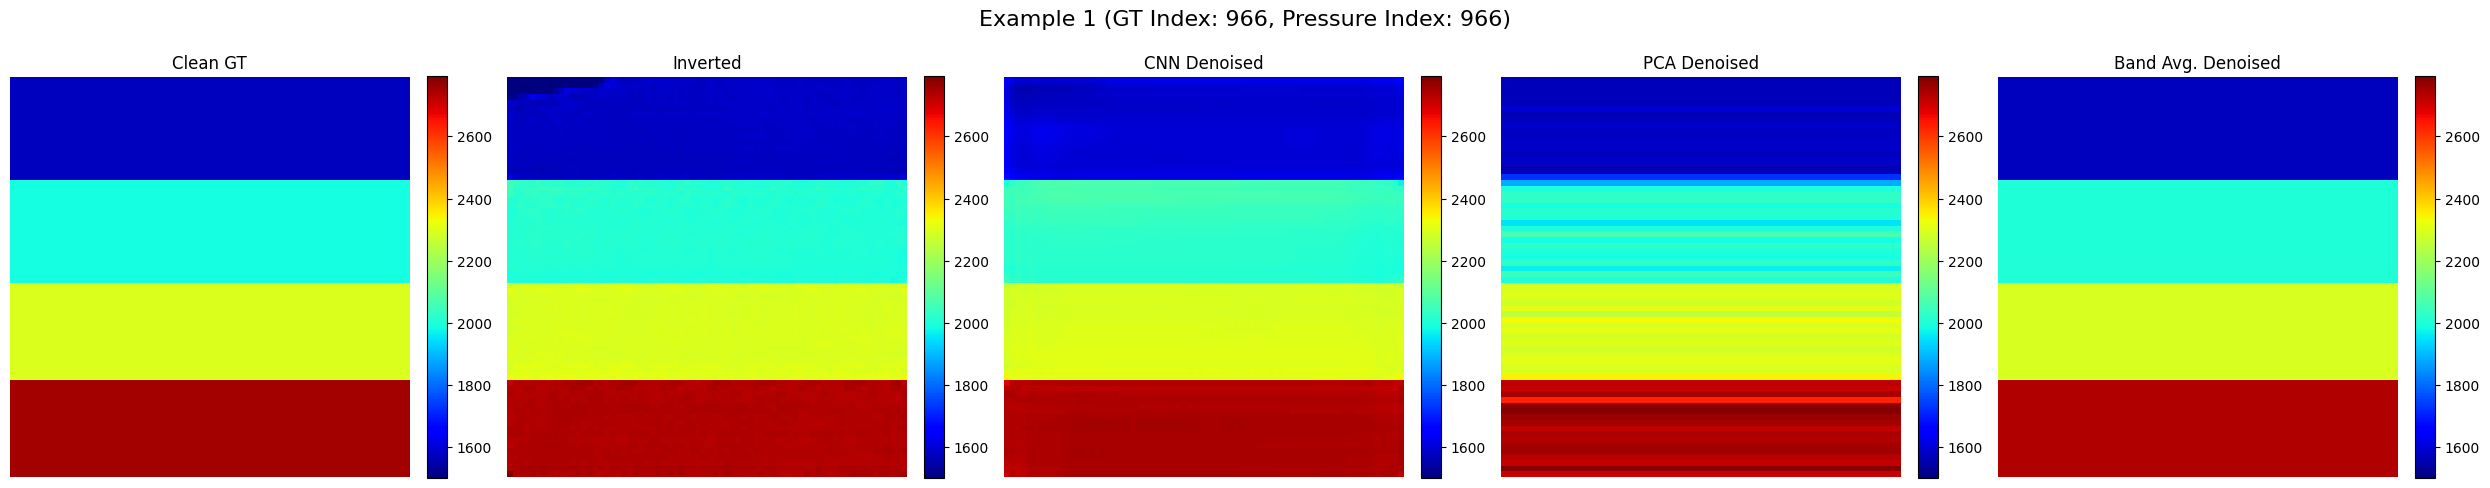


--- Example 2 (Index 789) ---


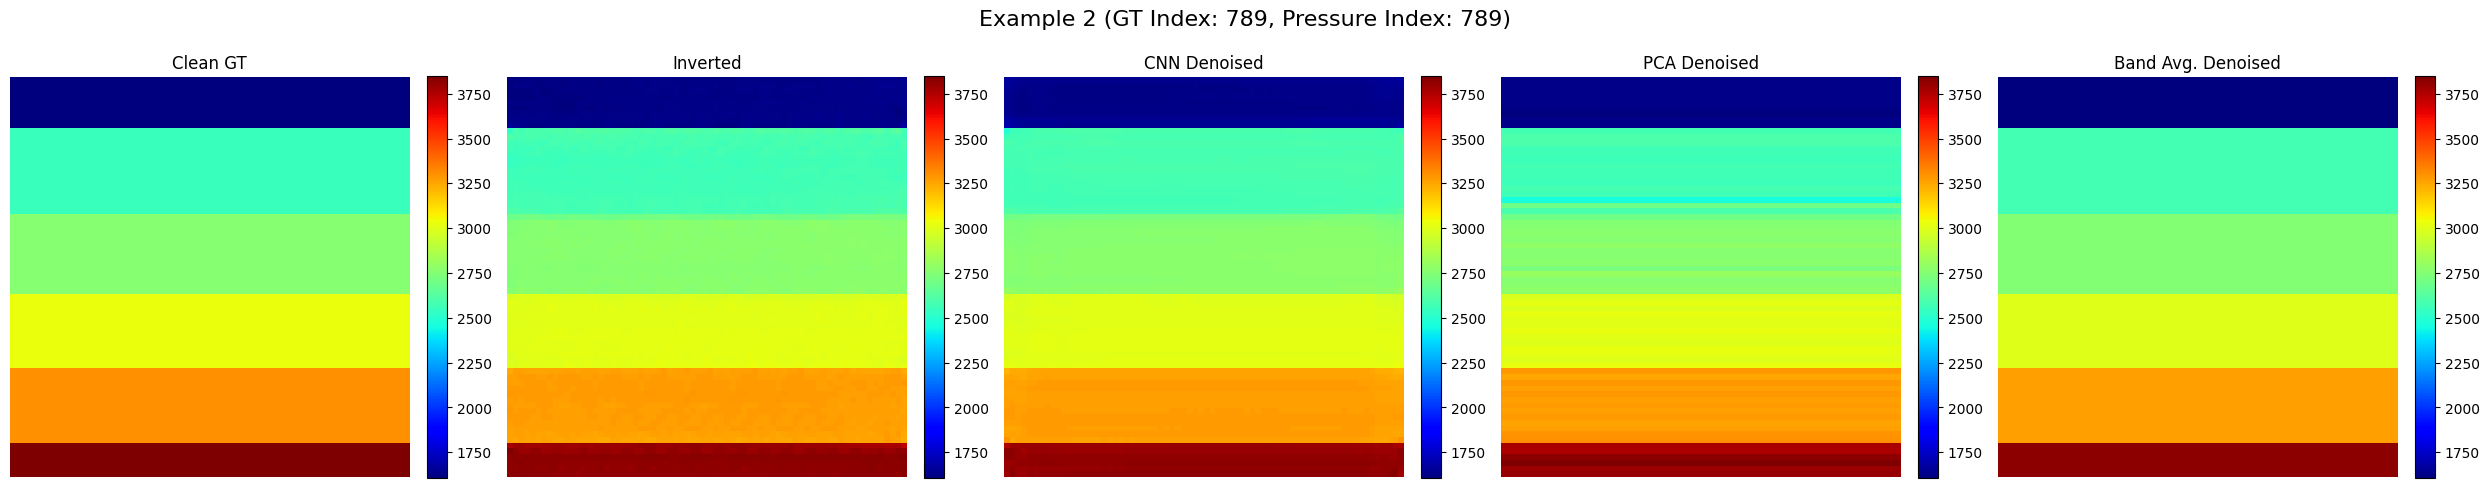


--- Example 3 (Index 77) ---


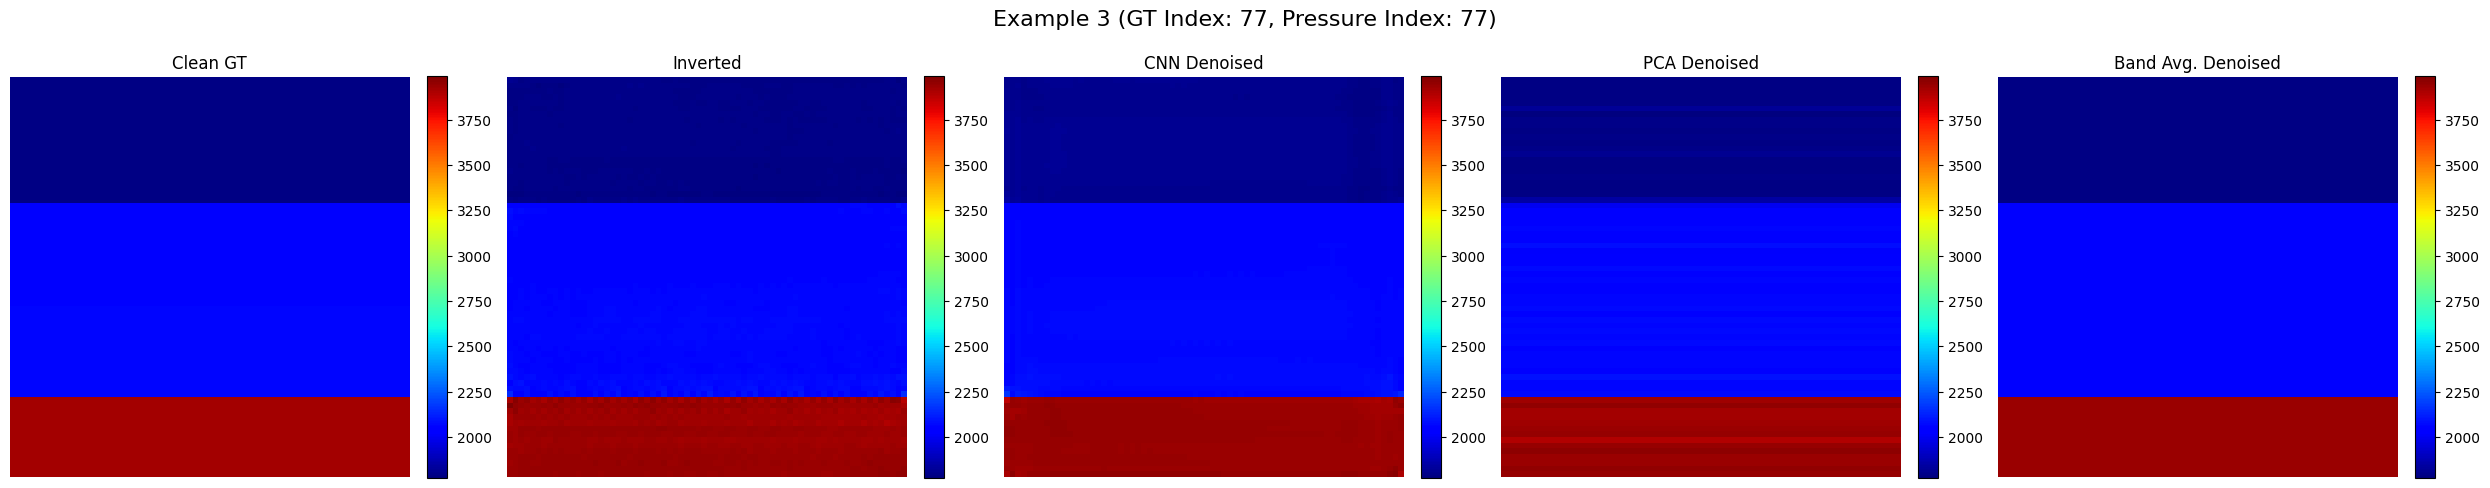

In [32]:
import glob
import pandas as pd
import os
import warnings
import json
warnings.filterwarnings("ignore", message=".*matmul.*")

# Add necessary imports for the inversion model (based on test.py)
import sys
sys.path.append('.')  # Add current directory to path for imports
try:
    import utils
    import network
    import transforms as T
    from torchvision.transforms import Compose
    INVNET_IMPORTS_AVAILABLE = True
    # print("Successfully imported InvNet modules") # Removed
except ImportError as e:
    print(f"Warning: Could not import InvNet modules: {e}")
    INVNET_IMPORTS_AVAILABLE = False

# --- 0. Configuration ---
MODEL_FAMILY = 'FlatVel_A'
BASE_PATH = f'data/train_samples/{MODEL_FAMILY}'
# print(f"Using base path: {BASE_PATH}") # Removed

# --- 1. Load Ground Truth Velocity Models & Define X_tensor, X_min, X_max, val_idx ---
gt_velocity_model_files = [
    os.path.join(BASE_PATH, 'model', 'model49.npy'),
    os.path.join(BASE_PATH, 'model', 'model50.npy')
]
gt_velocity_arrays = []
for f_path in gt_velocity_model_files:
    try:
        arr = np.load(f_path).astype(np.float32)
        if arr.ndim == 3: # Should be (samples, H, W) or (samples, 1, H, W)
            arr = arr[:, np.newaxis, ...] if arr.shape[1] != 70 else arr.reshape(-1, 1, arr.shape[-2], arr.shape[-1]) # ensure (N,1,H,W)
        elif arr.ndim == 4 and arr.shape[1] != 1 : # if (N,C,H,W) but C != 1
             arr = arr.reshape(-1,1,arr.shape[2],arr.shape[3]) # take first channel or reshape
        elif arr.ndim == 2: # if single image (H,W)
            arr = arr[np.newaxis, np.newaxis, ...] # make (1,1,H,W)
        gt_velocity_arrays.append(arr)
        # print(f"Loaded {f_path} with shape: {arr.shape}") # Removed
    except FileNotFoundError:
        print(f"Error: Ground truth velocity model file not found: {f_path}. Please check paths.")
        # Handle error, e.g., skip or use placeholder
if not gt_velocity_arrays:
    raise FileNotFoundError("No ground truth velocity models loaded. Stopping.")

X_gt_velocity_models = np.concatenate(gt_velocity_arrays, axis=0)
# print(f"Loaded ground truth velocity models, combined shape: {X_gt_velocity_models.shape}") # Removed

X_min, X_max = X_gt_velocity_models.min(), X_gt_velocity_models.max()
# print(f"Global Min/Max from GT velocity models: X_min={X_min}, X_max={X_max}") # Removed

# Normalize ground truth models
X_normalized_gt_models = (X_gt_velocity_models - X_min) / (X_max - X_min) if (X_max - X_min) > 1e-6 else np.zeros_like(X_gt_velocity_models)
X_tensor = torch.from_numpy(X_normalized_gt_models) # This is normalized GT for reference
gt_velocities_normalized = X_tensor.numpy().astype(np.float32) # For easy numpy access

dataset_size = X_tensor.shape[0]
val_idx = list(range(dataset_size)) # Use all loaded samples for validation/testing
# print(f"Validation indices (all loaded samples): {val_idx}") # Removed


# --- 2. Load Pre-trained Denoising U-Net Model ---
denoise_model_path = 'Invnet_models/trained_models/denoise_flatvel.pth'
denoiser_cnn = UNet().to(device) # UNet class must be defined
try:
    denoiser_cnn.load_state_dict(torch.load(denoise_model_path, map_location=device))
    denoiser_cnn.eval()
    # print(f"Loaded Denoising U-Net model from {denoise_model_path}") # Removed
except FileNotFoundError:
    print(f"Error: Denoising U-Net model file not found: {denoise_model_path}. CNN denoising will fail.")
    denoiser_cnn = None
except RuntimeError as e:
    print(f"Error loading Denoising U-Net model state_dict: {e}. Check UNet class definition. CNN denoising will fail.")
    denoiser_cnn = None


# --- 3. Load Pre-trained Inversion Model ---
inversion_model_path = 'Invnet_models/trained_models/winvnet_fva.pth'
dataset_key = 'flatvel-a'  # User specified dataset key for FlatVel-A
invnet_model_name = 'InversionNet'
inversion_model = None
ctx = None # Initialize ctx here

if INVNET_IMPORTS_AVAILABLE:
    try:
        # Load dataset configuration (needed for normalization parameters)
        with open('dataset_config.json') as f:
            config_data = json.load(f)
            ctx = config_data[dataset_key]
            
        # Based on test.py, the typical model names are like 'fcn', 'unet', 'winvnet', 'invnet' etc.
        # Check what models are available and try common ones
        # print(f"Available models in network.model_dict: {list(network.model_dict.keys())}") # Removed
        
        model_loaded = False
        
        try:
            inversion_model_instance = network.model_dict[invnet_model_name](
                upsample_mode=None, 
                sample_spatial=1.0, 
                sample_temporal=1, 
                norm='bn'
            ).to(device)
            
            checkpoint = torch.load(inversion_model_path, map_location=device, weights_only=False)
            # Handle different checkpoint formats
            if 'model' in checkpoint:
                state_dict = checkpoint['model']
            elif 'state_dict' in checkpoint:
                state_dict = checkpoint['state_dict']
            else:
                state_dict = checkpoint
                            
            inversion_model_instance.load_state_dict(network.replace_legacy(state_dict))
            inversion_model_instance.eval()
            
            inversion_model = inversion_model_instance # Assign to the main variable
            # print(f"Successfully loaded inversion model") # Removed
            if 'epoch' in checkpoint:
                # print(f"Model loaded at Epoch {checkpoint['epoch']}") # Removed
                pass # Keep the if, but no print
            
            model_loaded = True
            checkpoint_loaded = True
        except:
            print(f"Error initializing model : {e}")
            inversion_model = None
            
    except FileNotFoundError as e_file:
        print(f"Error: Dataset configuration file 'dataset_config.json' not found: {e_file}")
        inversion_model = None
        ctx = None
    except Exception as e_outer:
        print(f"Outer error loading inversion model: {e_outer}")
        print(f"Exception details: {type(e_outer).__name__}: {str(e_outer)}")
        inversion_model = None
        # ctx might be loaded, or not.
else:
    print("Skipping inversion model loading due to missing InvNet imports (INVNET_IMPORTS_AVAILABLE=False)")

# Pressure data preprocessing function (based on test.py)
def preprocess_pressure_data(pressure_batch, current_ctx, k=1): # Renamed ctx to current_ctx to avoid conflict
    """
    Preprocess pressure data before feeding to inversion model
    Based on test.py preprocessing pipeline
    """
    pressure_batch = pressure_batch.float().to(device)
    
    if INVNET_IMPORTS_AVAILABLE and current_ctx and 'data_min' in current_ctx and 'data_max' in current_ctx:
        try:
            # Apply log transformation and normalization as in test.py
            log_data_min = T.log_transform(current_ctx['data_min'], k=k)
            log_data_max = T.log_transform(current_ctx['data_max'], k=k)
            
            transform_data = Compose([
                T.LogTransform(k=k),
                T.MinMaxNormalize(log_data_min, log_data_max),
            ])
            
            # Apply transforms to each sample in the batch
            processed_batch_list = []
            for i_sample in range(pressure_batch.shape[0]):
                # Convert to numpy for transform, then back to tensor
                sample_np = pressure_batch[i_sample].cpu().numpy()
                transformed_sample = transform_data(sample_np)
                processed_batch_list.append(torch.from_numpy(transformed_sample))
            
            processed_tensor = torch.stack(processed_batch_list).to(device)
            # print(f"Applied log transform and normalization. Output range: [{processed_tensor.min():.4f}, {processed_tensor.max():.4f}]") # Keep for first sample
            return processed_tensor
        except Exception as e_preprocess:
            print(f"Error in preprocessing with transforms: {e_preprocess}")
            # Fall back to simple normalization
            pass
    
    # Simple normalization if transforms not available or failed
    print("Using simple normalization for pressure data (fallback or ctx missing keys)")
    batch_size = pressure_batch.shape[0]
    for i_sample in range(batch_size):
        # Normalize each sample independently to [-1, 1] range
        sample_item = pressure_batch[i_sample]
        sample_min_val = sample_item.min()
        sample_max_val = sample_item.max()
        if (sample_max_val - sample_min_val) > 1e-8: # Check for non-zero range
            pressure_batch[i_sample] = 2 * (sample_item - sample_min_val) / (sample_max_val - sample_min_val) - 1
        else:
            pressure_batch[i_sample] = torch.zeros_like(sample_item) # Or pressure_batch[i_sample] - sample_min_val
    return pressure_batch

# --- 4. Load Pressure Data ---
pressure_data_files = [
    os.path.join(BASE_PATH, 'data', 'data49.npy'),
    os.path.join(BASE_PATH, 'data', 'data50.npy')
]
pressure_arrays_list = []
for f_path in pressure_data_files:
    try:
        arr = np.load(f_path).astype(np.float32) # Shape (samples, 5, 1000, 70)
        pressure_arrays_list.append(arr)
        # print(f"Loaded pressure data {f_path} with shape: {arr.shape}") # Removed
    except FileNotFoundError:
        print(f"Error: Pressure data file not found: {f_path}. Check paths.")

if not pressure_arrays_list:
    print(f"Warning: No pressure data files loaded. Using placeholder for inverted maps.")
    # Ensure P_tensor has a compatible number of samples with val_idx
    P_tensor = torch.rand(len(val_idx), 5, 1000, 70).float() # Placeholder
else:
    # Assuming each file could have multiple samples, or one sample that needs unsqueezing
    # For OpenFWI, data files usually have (N_samples_in_file, sources, time, receivers)
    # If each file is one sample, they might be (sources, time, receivers)
    # Let's assume they are (N_samples_in_file, sources, time, receivers) or need to be concatenated carefully
    # For simplicity, if shapes are (5,1000,70), add batch dim.
    processed_pressure_arrays = []
    for arr in pressure_arrays_list:
        if arr.ndim == 3 and arr.shape == (5, 1000, 70): # (sources, time, receivers)
            processed_pressure_arrays.append(arr[np.newaxis, ...]) # Add batch dim -> (1, 5, 1000, 70)
        elif arr.ndim == 4 and arr.shape[1:] == (5, 1000, 70): # (N, sources, time, receivers)
            processed_pressure_arrays.append(arr)
        else:
            print(f"Warning: Pressure data file has unexpected shape {arr.shape}. Skipping.")
    if processed_pressure_arrays:
        P_all = np.concatenate(processed_pressure_arrays, axis=0)
        P_tensor = torch.from_numpy(P_all)
    else:
        print(f"Warning: No valid pressure data loaded. Using placeholder.")
        P_tensor = torch.rand(len(val_idx), 5, 1000, 70).float()

# print(f"Loaded pressure data, P_tensor shape: {P_tensor.shape}") # Removed
if P_tensor.shape[0] < len(val_idx):
    print(f"Warning: Not enough pressure samples ({P_tensor.shape[0]}) for all validation indices ({len(val_idx)}). Results might be incomplete or use placeholders.")


# --- 5. Evaluation Loop ---
mse_cnn_inv, psnr_cnn_inv, ssim_cnn_inv = [], [], []
mse_pca_inv, psnr_pca_inv, ssim_pca_inv = [], [], []
mse_band_inv, psnr_band_inv, ssim_band_inv = [], [], []

# PCA related: X_mean is from cell 13, derived from original scale velocity data.
# pca object is also from cell 13.

for i, current_idx_in_gt in enumerate(val_idx): # current_idx_in_gt refers to index in X_tensor/gt_velocities_normalized
    if i >= P_tensor.shape[0]: # Ensure we don't go out of bounds for pressure data
        print(f"Warning: Not enough pressure data samples for all val_idx. Stopping at pressure sample {i}.")
        break

    # Get ground truth clean velocity map (original scale)
    clean_vel_norm = gt_velocities_normalized[current_idx_in_gt, 0] # Assuming single channel (H,W)
    clean_vel_orig = clean_vel_norm * (X_max - X_min) + X_min

    # Get corresponding pressure data sample and preprocess
    pressure_sample = P_tensor[i].unsqueeze(0)  # Add batch dimension
    # Pass the 'ctx' loaded earlier for dataset config
    pressure_sample_processed = preprocess_pressure_data(pressure_sample, ctx) 
    
    if i == 0:  # Print debug info for first sample only
        # print(f"Sample {i}: Pressure input shape: {pressure_sample.shape}, Processed shape: {pressure_sample_processed.shape}") # Removed
        # print(f"Sample {i}: Pressure input range: [{pressure_sample.min():.4f}, {pressure_sample.max():.4f}]") # Removed
        # print(f"Sample {i}: Processed data range for model: [{pressure_sample_processed.min():.4f}, {pressure_sample_processed.max():.4f}]") # Removed
        pass # Keep the if block for potential future debug prints

    # Perform Inversion to get "noisy" velocity map (original scale)
    inverted_vel_orig = None
    if inversion_model is not None:
        try:
            with torch.no_grad():
                inverted_vel_tensor = inversion_model(pressure_sample_processed)
                
            if i == 0:  # Print debug info for first sample only
                # print(f"Sample {i}: Inversion model output tensor shape: {inverted_vel_tensor.shape}") # Removed
                # print(f"Sample {i}: Inversion model output tensor range: [{inverted_vel_tensor.min():.4f}, {inverted_vel_tensor.max():.4f}]") # Removed
                pass # Keep the if block
                
            # Handle different possible output shapes and denormalize
            # Ensure ctx is not None and has the required keys for denormalization
            if INVNET_IMPORTS_AVAILABLE and ctx and 'label_min' in ctx and 'label_max' in ctx:
                try:
                    # Denormalize using the same method as in test.py
                    inverted_vel_np_array = T.tonumpy_denormalize(
                        inverted_vel_tensor, 
                        ctx['label_min'], 
                        ctx['label_max'], 
                        exp=False # Assuming exp=False based on typical velocity model scales
                    )
                    # inverted_vel_np_array should be (N, C, H, W)
                    if inverted_vel_np_array.ndim == 4 and inverted_vel_np_array.shape[0] == 1 and inverted_vel_np_array.shape[1] == 1:
                        inverted_vel_orig = inverted_vel_np_array[0, 0].astype(np.float32)  # Extract (H,W)
                    elif inverted_vel_np_array.ndim == 3 and inverted_vel_np_array.shape[0] == 1: # (N, H, W) if C=1 was squeezed by denorm
                        inverted_vel_orig = inverted_vel_np_array[0].astype(np.float32)
                    elif inverted_vel_np_array.ndim == 2: # (H,W) if N=1, C=1 were squeezed
                         inverted_vel_orig = inverted_vel_np_array.astype(np.float32)
                    else:
                        print(f"Warning: Denormalized array shape {inverted_vel_np_array.shape} not as expected. Squeezing.")
                        inverted_vel_orig = inverted_vel_tensor.squeeze().cpu().numpy().astype(np.float32) # Fallback to simple squeeze

                    if i == 0 and inverted_vel_orig is not None:
                        # print(f"Sample {i}: After InvNet denormalization, shape: {inverted_vel_orig.shape}, range: [{inverted_vel_orig.min():.4f}, {inverted_vel_orig.max():.4f}]") # Removed
                        pass # Keep the if block
                except Exception as e_denorm:
                    print(f"Error in InvNet denormalization: {e_denorm}, using simple extraction and scaling.")
                    inverted_vel_orig = inverted_vel_tensor.squeeze().cpu().numpy().astype(np.float32)

                    # Simple denormalization: assume output is in [-1, 1] and scale to original GT range
                    if inverted_vel_orig.min() >= -1.1 and inverted_vel_orig.max() <= 1.1: # Check if it looks like [-1,1]
                        inverted_vel_orig = (inverted_vel_orig + 1) / 2.0  # Scale from [-1, 1] to [0, 1]
                        inverted_vel_orig = inverted_vel_orig * (X_max - X_min) + X_min  # Scale from [0, 1] to original GT range [X_min, X_max]
            else:
                if i == 0:
                    # print("Using simple extraction and scaling for inverted velocity (ctx or keys missing).") # Removed
                    pass # Keep the if block
                inverted_vel_orig = inverted_vel_tensor.squeeze().cpu().numpy().astype(np.float32)

            if i == 0 and inverted_vel_orig is not None:
                # print(f"Sample {i}: Final inverted_vel_orig shape: {inverted_vel_orig.shape}, range: [{inverted_vel_orig.min():.4f}, {inverted_vel_orig.max():.4f}]") # Removed
                # print(f"Sample {i}: clean_vel_orig (GT) shape: {clean_vel_orig.shape}, range: [{clean_vel_orig.min():.4f}, {clean_vel_orig.max():.4f}]") # Removed
                pass # Keep the if block
                
            # Ensure correct shape match with ground truth
            if inverted_vel_orig is not None and inverted_vel_orig.shape != clean_vel_orig.shape:
                # print(f"Warning: Inverted map shape {inverted_vel_orig.shape} mismatch with GT {clean_vel_orig.shape}. Attempting reshape.") # Potentially keep if issues persist
                if inverted_vel_orig.size == clean_vel_orig.size:
                    try:
                        inverted_vel_orig = inverted_vel_orig.reshape(clean_vel_orig.shape)
                        # if i == 0: print(f"Reshaped inverted_vel_orig to {clean_vel_orig.shape}") # Removed
                    except Exception as e_reshape:
                        print(f"Error reshaping: {e_reshape}. Setting inverted_vel_orig to None.")
                        inverted_vel_orig = None
                else:
                    print(f"Size mismatch: Inverted map size {inverted_vel_orig.size} vs GT size {clean_vel_orig.size}. Setting inverted_vel_orig to None.")
                    inverted_vel_orig = None
                    
        except Exception as e_inv_model:
            print(f"Error during inversion model call for sample {current_idx_in_gt}: {e_inv_model}")
            inverted_vel_orig = None

    if inverted_vel_orig is None: # Fallback if inversion model failed or error during inversion
        if i == 0: # Print only for the first sample to avoid clutter
            # print(f"Warning: inverted_vel_orig is None. Using noisy version of clean map as placeholder for inverted map for sample {current_idx_in_gt}.") # Potentially keep
            pass
        noise_level = 0.15 * (clean_vel_orig.max() - clean_vel_orig.min() + 1e-6)
        inverted_vel_orig = clean_vel_orig + noise_level * np.random.randn(*clean_vel_orig.shape).astype(np.float32)
        inverted_vel_orig = np.clip(inverted_vel_orig, X_min, X_max)


    # --- CNN Denoise ---
    out_cnn_orig = np.copy(inverted_vel_orig) # Default to inverted if CNN fails
    if denoiser_cnn is not None:
        inverted_vel_norm_for_cnn = (inverted_vel_orig - X_min) / (X_max - X_min + 1e-6)
        inverted_vel_norm_for_cnn = np.clip(inverted_vel_norm_for_cnn, 0.0, 1.0)
        inp_cnn = torch.from_numpy(inverted_vel_norm_for_cnn).unsqueeze(0).unsqueeze(0).to(device)
        with torch.no_grad():
            out_cnn_norm_tensor = denoiser_cnn(inp_cnn)
        out_cnn_norm = out_cnn_norm_tensor.squeeze().cpu().numpy()
        out_cnn_orig = out_cnn_norm * (X_max - X_min) + X_min
        out_cnn_orig = np.clip(out_cnn_orig, X_min, X_max)
    else:
        print(f"Skipping CNN denoising for sample {current_idx_in_gt} as model is not loaded.")


    # --- PCA Denoise (applied to original scale data) ---
    # X_mean and pca are from cell 13, trained on original scale data.
    out_pca_orig = np.copy(inverted_vel_orig) # Default to inverted if PCA fails
    try:
        pca_input_orig_flat = inverted_vel_orig.flatten().astype(np.float32)
        # Ensure X_mean has the same number of features as pca_input_orig_flat
        if X_mean.shape[0] == pca_input_orig_flat.shape[0]:
            pca_input_orig_centered = pca_input_orig_flat - X_mean
            pca_coeffs = pca.transform(pca_input_orig_centered.reshape(1, -1))
            recon_pca_orig_centered_flat = pca.inverse_transform(pca_coeffs)
            recon_pca_orig_flat = recon_pca_orig_centered_flat.reshape(-1) + X_mean
            out_pca_orig = recon_pca_orig_flat.reshape(clean_vel_orig.shape)
            out_pca_orig = np.clip(out_pca_orig, X_min, X_max)
        else:
            print(f"Skipping PCA for sample {current_idx_in_gt}: X_mean shape {X_mean.shape} mismatch with flattened data {pca_input_orig_flat.shape}.")
    except Exception as e_pca:
        print(f"Error during PCA denoising for sample {current_idx_in_gt}: {e_pca}")


    # --- Band-averaging Denoise ---
    # band_denoising expects original scale data
    out_band_orig = np.copy(inverted_vel_orig) # Default to inverted if band avg fails
    try:
        noise_std_heuristic_inverted = 0.1 * (inverted_vel_orig.max() - inverted_vel_orig.min() + 1e-6)
        # The band_denoising function adds its own noise based on the passed clean_map and noise_std.
        # For denoising an already noisy map (inverted_vel_orig), we should modify band_denoising
        # or pass inverted_vel_orig as the 'clean_map' and estimate its noise.
        # Let's assume band_denoising is modified to take a noisy map directly or we use a wrapper.
        # For now, using it as is, which means it will add MORE noise then denoise.
        # This is not ideal. A better band_denoising for this context would be:
        # def band_denoising_on_noisy(noisy_map_input, estimated_noise_std, window=5): ...
        # Using current band_denoising:
        _, out_band_orig_temp, _ = band_denoising(inverted_vel_orig.astype(np.float32), noise_std_heuristic_inverted)
        # The first output of band_denoising is noisy_map (input + new noise), second is recon_map. We want recon_map.
        out_band_orig = np.clip(out_band_orig_temp, X_min, X_max)
    except Exception as e_band:
        print(f"Error during Band Averaging for sample {current_idx_in_gt}: {e_band}")


    # Compute MSE, PSNR, SSIM metrics in original scale
    data_range_orig = X_max - X_min
    if data_range_orig < 1e-6: data_range_orig = 1.0 # Avoid division by zero if X_max == X_min

    mse_c = np.mean((out_cnn_orig - clean_vel_orig) ** 2)
    ps_c = peak_signal_noise_ratio(clean_vel_orig, out_cnn_orig, data_range=data_range_orig)
    ss_c = structural_similarity(clean_vel_orig, out_cnn_orig, data_range=data_range_orig)
    mse_cnn_inv.append(mse_c); psnr_cnn_inv.append(ps_c); ssim_cnn_inv.append(ss_c)

    mse_p = np.mean((out_pca_orig - clean_vel_orig) ** 2)
    ps_p = peak_signal_noise_ratio(clean_vel_orig, out_pca_orig, data_range=data_range_orig)
    ss_p = structural_similarity(clean_vel_orig, out_pca_orig, data_range=data_range_orig)
    mse_pca_inv.append(mse_p); psnr_pca_inv.append(ps_p); ssim_pca_inv.append(ss_p)

    mse_b = np.mean((out_band_orig - clean_vel_orig) ** 2)
    ps_b = peak_signal_noise_ratio(clean_vel_orig, out_band_orig, data_range=data_range_orig)
    ss_b = structural_similarity(clean_vel_orig, out_band_orig, data_range=data_range_orig)
    mse_band_inv.append(mse_b); psnr_band_inv.append(ps_b); ssim_band_inv.append(ss_b)

# Compute average metrics for the validation set
avg_mse_cnn_inv  = np.mean(mse_cnn_inv)   if mse_cnn_inv else np.nan
avg_psnr_cnn_inv = np.mean(psnr_cnn_inv)  if psnr_cnn_inv else np.nan
avg_ssim_cnn_inv = np.mean(ssim_cnn_inv)  if ssim_cnn_inv else np.nan

avg_mse_pca_inv  = np.mean(mse_pca_inv)   if mse_pca_inv else np.nan
avg_psnr_pca_inv = np.mean(psnr_pca_inv)  if psnr_pca_inv else np.nan
avg_ssim_pca_inv = np.mean(ssim_pca_inv)  if ssim_pca_inv else np.nan

avg_mse_band_inv = np.mean(mse_band_inv)  if mse_band_inv else np.nan
avg_psnr_band_inv= np.mean(psnr_band_inv) if psnr_band_inv else np.nan
avg_ssim_band_inv= np.mean(ssim_band_inv) if ssim_band_inv else np.nan

# Summary table of metrics
df_inv = pd.DataFrame({
    "Method": ["CNN (U-Net)", "PCA", "Band Avg."],
    "MSE":   [avg_mse_cnn_inv, avg_mse_pca_inv, avg_mse_band_inv],
    "PSNR":  [avg_psnr_cnn_inv, avg_psnr_pca_inv, avg_psnr_band_inv],
    "SSIM":  [avg_ssim_cnn_inv, avg_ssim_pca_inv, avg_ssim_band_inv]
})
df_inv[["MSE", "PSNR", "SSIM"]] = df_inv[["MSE", "PSNR", "SSIM"]].round(4)
print("\n--- Denoising Performance on Inverted Velocity Maps ---") # Keep this one
print(df_inv)

# Plot a representative validation example (clean, inverted, and denoised results)
num_available_samples_for_plot = min(len(val_idx), P_tensor.shape[0])

if num_available_samples_for_plot > 0:
    num_examples_to_plot = min(3, num_available_samples_for_plot) # Plot up to 3 examples
    
    # Ensure val_idx is not empty before trying to choose from it
    if not val_idx:
        print("Skipping example plot as val_idx is empty.")
    else:
        # Ensure we are choosing from valid indices for both val_idx and P_tensor
        possible_indices = list(range(min(len(val_idx), P_tensor.shape[0])))
        if not possible_indices:
            print("Skipping example plot as there are no common samples between val_idx and P_tensor.")
        else:
            # If num_examples_to_plot is greater than available, adjust it
            actual_num_to_plot = min(num_examples_to_plot, len(possible_indices))
            if actual_num_to_plot == 0:
                 print("Skipping example plot as no samples can be plotted.")
            else:
                plot_indices = np.random.choice(possible_indices, size=actual_num_to_plot, replace=False)

                print(f"\n--- Plotting {actual_num_to_plot} Random Validation Examples ---")

                for plot_counter, ex_idx in enumerate(plot_indices):
                    print(f"\n--- Example {plot_counter + 1} (Index {ex_idx}) ---")
                    # ex_idx is an index that is valid for both P_tensor and for indexing into val_idx
                    ex_gt_idx = val_idx[ex_idx] # Index in the original GT dataset (X_tensor, gt_velocities_normalized)
                    ex_pressure_idx = ex_idx    # Corresponding index in P_tensor
        
                    # Ground truth
                    clean_vel_norm_ex = gt_velocities_normalized[ex_gt_idx, 0]
                    clean_vel_orig_ex = clean_vel_norm_ex * (X_max - X_min) + X_min
        
                    # Inverted (re-calculate for plotting to ensure consistency)
                    pressure_sample_ex_raw = P_tensor[ex_pressure_idx].unsqueeze(0).to(device)
                    # Preprocess the pressure data for the example plot
                    pressure_sample_ex_processed = preprocess_pressure_data(pressure_sample_ex_raw, ctx)
        
                    inverted_vel_orig_ex = None
                    if inversion_model is not None:
                        try:
                            with torch.no_grad():
                                # Use preprocessed pressure data
                                inverted_vel_tensor_ex = inversion_model(pressure_sample_ex_processed)
                            
                            # Correctly denormalize inverted_vel_tensor_ex
                            if INVNET_IMPORTS_AVAILABLE and ctx and 'label_min' in ctx and 'label_max' in ctx:
                                try:
                                    inverted_vel_np_array_ex = T.tonumpy_denormalize(
                                        inverted_vel_tensor_ex,
                                        ctx['label_min'],
                                        ctx['label_max'],
                                        exp=False # Consistent with main loop
                                    )
                                    if inverted_vel_np_array_ex.ndim == 4 and inverted_vel_np_array_ex.shape[0] == 1 and inverted_vel_np_array_ex.shape[1] == 1:
                                        inverted_vel_orig_ex = inverted_vel_np_array_ex[0, 0].astype(np.float32)
                                    elif inverted_vel_np_array_ex.ndim == 3 and inverted_vel_np_array_ex.shape[0] == 1:
                                        inverted_vel_orig_ex = inverted_vel_np_array_ex[0].astype(np.float32)
                                    elif inverted_vel_np_array_ex.ndim == 2:
                                         inverted_vel_orig_ex = inverted_vel_np_array_ex.astype(np.float32)
                                    else:
                                        # print(f"Plotting: Denormalized array shape {inverted_vel_np_array_ex.shape} not as expected. Squeezing tensor.") # Potentially keep
                                        inverted_vel_orig_ex = inverted_vel_tensor_ex.squeeze().cpu().numpy().astype(np.float32) # Fallback
                                except Exception as e_denorm_plot:
                                    print(f"Plotting Example {plot_counter + 1}: Error in InvNet denormalization: {e_denorm_plot}. Using simple scaling.")
                                    inverted_vel_orig_ex = inverted_vel_tensor_ex.squeeze().cpu().numpy().astype(np.float32)
                                    if inverted_vel_orig_ex.min() >= -1.1 and inverted_vel_orig_ex.max() <= 1.1: # Check if it looks like [-1,1]
                                        inverted_vel_orig_ex = (inverted_vel_orig_ex + 1) / 2.0
                                        inverted_vel_orig_ex = inverted_vel_orig_ex * (X_max - X_min) + X_min
                            else:
                                # print("Plotting: Using simple extraction and scaling for inverted velocity (ctx or keys missing).") # Potentially keep
                                inverted_vel_orig_ex = inverted_vel_tensor_ex.squeeze().cpu().numpy().astype(np.float32)
                                if inverted_vel_orig_ex.min() >= -1.1 and inverted_vel_orig_ex.max() <= 1.1: # Check if it looks like [-1,1]
                                    inverted_vel_orig_ex = (inverted_vel_orig_ex + 1) / 2.0
                                    inverted_vel_orig_ex = inverted_vel_orig_ex * (X_max - X_min) + X_min
                            
                            # Ensure correct shape match with ground truth
                            if inverted_vel_orig_ex is not None and inverted_vel_orig_ex.shape != clean_vel_orig_ex.shape:
                                # print(f"Plotting Example {plot_counter + 1}: Inverted map shape {inverted_vel_orig_ex.shape} mismatch with GT {clean_vel_orig_ex.shape}. Attempting reshape.") # Potentially keep
                                if inverted_vel_orig_ex.size == clean_vel_orig_ex.size:
                                    try:
                                        inverted_vel_orig_ex = inverted_vel_orig_ex.reshape(clean_vel_orig_ex.shape)
                                    except Exception as e_reshape_plot:
                                        print(f"Plotting Example {plot_counter + 1}: Error reshaping: {e_reshape_plot}. Setting inverted_vel_orig_ex to None.")
                                        inverted_vel_orig_ex = None
                                else:
                                    print(f"Plotting Example {plot_counter + 1}: Size mismatch. Setting inverted_vel_orig_ex to None.")
                                    inverted_vel_orig_ex = None
        
                        except Exception as e_inv_model_plot:
                            print(f"Plotting Example {plot_counter + 1}: Error during inversion model call: {e_inv_model_plot}")
                            inverted_vel_orig_ex = None
                    
                    if inverted_vel_orig_ex is None: # Fallback if inversion failed for plotting
                        # print(f"Plotting Example {plot_counter + 1}: inverted_vel_orig_ex is None. Using noisy GT as placeholder.") # Potentially keep
                        noise_level = 0.15 * (clean_vel_orig_ex.max() - clean_vel_orig_ex.min() + 1e-6)
                        inverted_vel_orig_ex = clean_vel_orig_ex + noise_level * np.random.randn(*clean_vel_orig_ex.shape).astype(np.float32)
                        inverted_vel_orig_ex = np.clip(inverted_vel_orig_ex, X_min, X_max)


                    # CNN Denoised
                    out_cnn_orig_ex = np.copy(inverted_vel_orig_ex)
                    if denoiser_cnn is not None:
                        inverted_vel_norm_ex_cnn = (inverted_vel_orig_ex - X_min) / (X_max - X_min + 1e-6)
                        inverted_vel_norm_ex_cnn = np.clip(inverted_vel_norm_ex_cnn, 0.0, 1.0)
                        inp_cnn_ex = torch.from_numpy(inverted_vel_norm_ex_cnn).unsqueeze(0).unsqueeze(0).to(device)
                        with torch.no_grad():
                            out_cnn_norm_tensor_ex = denoiser_cnn(inp_cnn_ex)
                        out_cnn_norm_ex = out_cnn_norm_tensor_ex.squeeze().cpu().numpy()
                        out_cnn_orig_ex = np.clip(out_cnn_norm_ex * (X_max - X_min) + X_min, X_min, X_max)

                    # PCA Denoised
                    out_pca_orig_ex = np.copy(inverted_vel_orig_ex)
                    try:
                        pca_input_orig_flat_ex = inverted_vel_orig_ex.flatten().astype(np.float32)
                        if X_mean.shape[0] == pca_input_orig_flat_ex.shape[0]:
                            pca_input_orig_centered_ex = pca_input_orig_flat_ex - X_mean
                            pca_coeffs_ex = pca.transform(pca_input_orig_centered_ex.reshape(1, -1))
                            recon_pca_orig_centered_flat_ex = pca.inverse_transform(pca_coeffs_ex)
                            recon_pca_orig_flat_ex = recon_pca_orig_centered_flat_ex.reshape(-1) + X_mean
                            out_pca_orig_ex = recon_pca_orig_flat_ex.reshape(clean_vel_orig_ex.shape)
                            out_pca_orig_ex = np.clip(out_pca_orig_ex, X_min, X_max)
                    except: pass # Error already printed in loop

                    # Band Avg Denoised
                    out_band_orig_ex = np.copy(inverted_vel_orig_ex)
                    try:
                        noise_std_inverted_ex = 0.1 * (inverted_vel_orig_ex.max() - inverted_vel_orig_ex.min() + 1e-6)
                        _, out_band_orig_temp_ex, _ = band_denoising(inverted_vel_orig_ex.astype(np.float32), noise_std_inverted_ex)
                        out_band_orig_ex = np.clip(out_band_orig_temp_ex, X_min, X_max)
                    except: pass # Error already printed in loop


                    # Display the results (original scale)
                    fig, axs = plt.subplots(1, 5, figsize=(25, 5))
                    fig.suptitle(f"Example {plot_counter + 1} (GT Index: {ex_gt_idx}, Pressure Index: {ex_pressure_idx})", fontsize=16)
                    maps_to_plot = [clean_vel_orig_ex, inverted_vel_orig_ex, out_cnn_orig_ex, out_pca_orig_ex, out_band_orig_ex]
                    titles = ["Clean GT", "Inverted", "CNN Denoised", "PCA Denoised", "Band Avg. Denoised"]
                    
                    plot_vmin = min(m.min() for m in maps_to_plot if m is not None)
                    plot_vmax = max(m.max() for m in maps_to_plot if m is not None)
                    if plot_vmax - plot_vmin < 1e-6: plot_vmax = plot_vmin + 1.0


                    for ax, img, title in zip(axs, maps_to_plot, titles):
                        if img is not None:
                            im = ax.imshow(img, cmap="jet", vmin=plot_vmin, vmax=plot_vmax)
                            ax.set_title(title)
                            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
                        else:
                            ax.set_title(f"{title}\n(Error)")
                        ax.axis("off")

                    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
                    plt.show()
else:
    print("Skipping example plot due to missing validation indices, pressure data, or GT data.")